# Searching for Exoplanets with TESS and Lightkurve

This tutorial is based primarily on the [TESS tutorial](https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-recover-first-tess-candidate.html) from Geert Barentsen and the Lightkurve developers.

TESS observes each sector of sky for 27 days at a time, monitoring stars in the sky for tiny changes in brightness, possibly due to a planet passing in front of the star. For roughly 200,000 stars per sector, the brightness is recorded every two minutes. For the rest of the sky, the data was only recorded once every 30 minutes during the first two years of TESS' Prime Mission, and once every 10 minutes during the current Extended Mission.

The data from TESS is downloaded to the Earth, and processed and uploaded to the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/missions-and-data/tess) just a few weeks later. All the data is made publicly available, which means anyone can access the data!

We will be using the Python package [_lightkurve_](https://github.com/lightkurve/lightkurve) to download and examine some TESS data.

## Installing lightkurve

To install lightkurve, you can run the following command from a Jupyter notebook, or the same command (excluding the ! mark) in a terminal window.

If you hve any trouble, there are further instructions on [this page](https://docs.lightkurve.org/about/install.html)

In [ ]:
! python -m pip install lightkurve --upgrade

## TESS' First Exoplanet

In this tutorial, we will search for and recover TESS' first exoplanet, Pi Mensae c, published by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).

To begin, we will import the packages we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy import units as u

%matplotlib inline

## Searching for data

The _lightkurve_ package has a function that allows you to search for and download the data from a star, if available:

In [2]:
search_results = lk.search_lightcurve('Pi Mensae', mission='TESS', author='SPOC')
search_results

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,261136679,0.0
1,TESS Sector 04,2018,SPOC,120,261136679,0.0
2,TESS Sector 08,2019,SPOC,120,261136679,0.0
3,TESS Sector 11,2019,SPOC,120,261136679,0.0
4,TESS Sector 12,2019,SPOC,120,261136679,0.0
5,TESS Sector 13,2019,SPOC,120,261136679,0.0
6,TESS Sector 27,2020,SPOC,20,261136679,0.0
7,TESS Sector 27,2020,SPOC,120,261136679,0.0
8,TESS Sector 28,2020,SPOC,20,261136679,0.0


In our query, we restricted our search to the _TESS_ mission (lightkurve also allows you to download MAST data from Kepler and K2), and to light curves processed by the TESS Science Processing Operations Center (SPOC) at NASA. Data from other processing pipelines is also available.

We also performed our search by the name of the star, Pi Mensae. Most stars don't have names and you can also search for data using other identifiers, such as the TESS Input Catalog (TIC) ID. For example, for this target, you could search:
```python
lk.search_lightcurve('TIC 261136679', mission='TESS', author='SPOC')
```
to get the same results.

## Downloading data

Our search results returned many light curves for the same star, because Pi Mensae has been observed in many sectors (1, 4, 8, 11, 12, 13, 27, 28, 31, 34, 38, 39). In some of the later sectors, this star was also selected for 20-second cadence observations.

For this tutorial, we will focus on just the first sector of observations. To download the data, we run the following code:

In [3]:
# The index here refers to the first column of the search_results table above.
lc = search_results[0].download()

We can examine the data simply by plotting it:

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='sap_flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

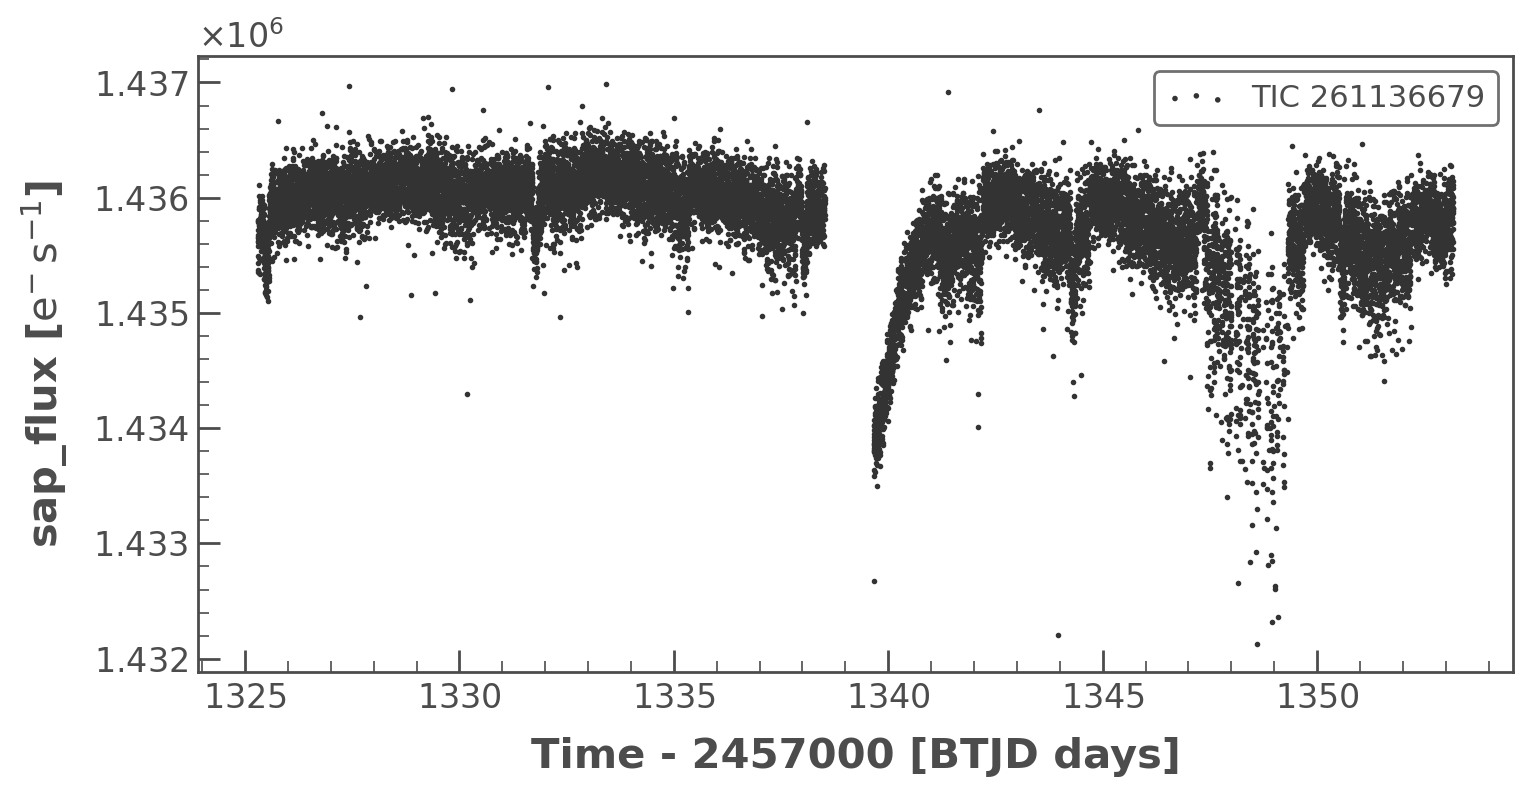

In [4]:
lc.scatter(column='sap_flux')

We have plotted the `sap_flux` column (SAP: Simple Aperture Photometry) column here.

You can see a gap in the middle of the data -- that corresponds to a real gap in observations that occurs while TESS is downloading data to the Earth. You might also see some data issues between BTJD = 1347 and 1349, whihc were due to a pointing anomaly. There are some dips in brightness that may be a transit signal, but there are also jumps in the data due to momentum dumps. From this light-curve, it's not easy to tell which are transits.

## Cleaning the data

You might be able to spot the transits by eye already, but the data is somewhat messy, especially following the data downlink. For the SPOC light curves, they also produce PDCSAP light curves (PDC: Presearch Data Conditioning), which are corrected for some of the spacecraft systematics. Let's select that column and plot it.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

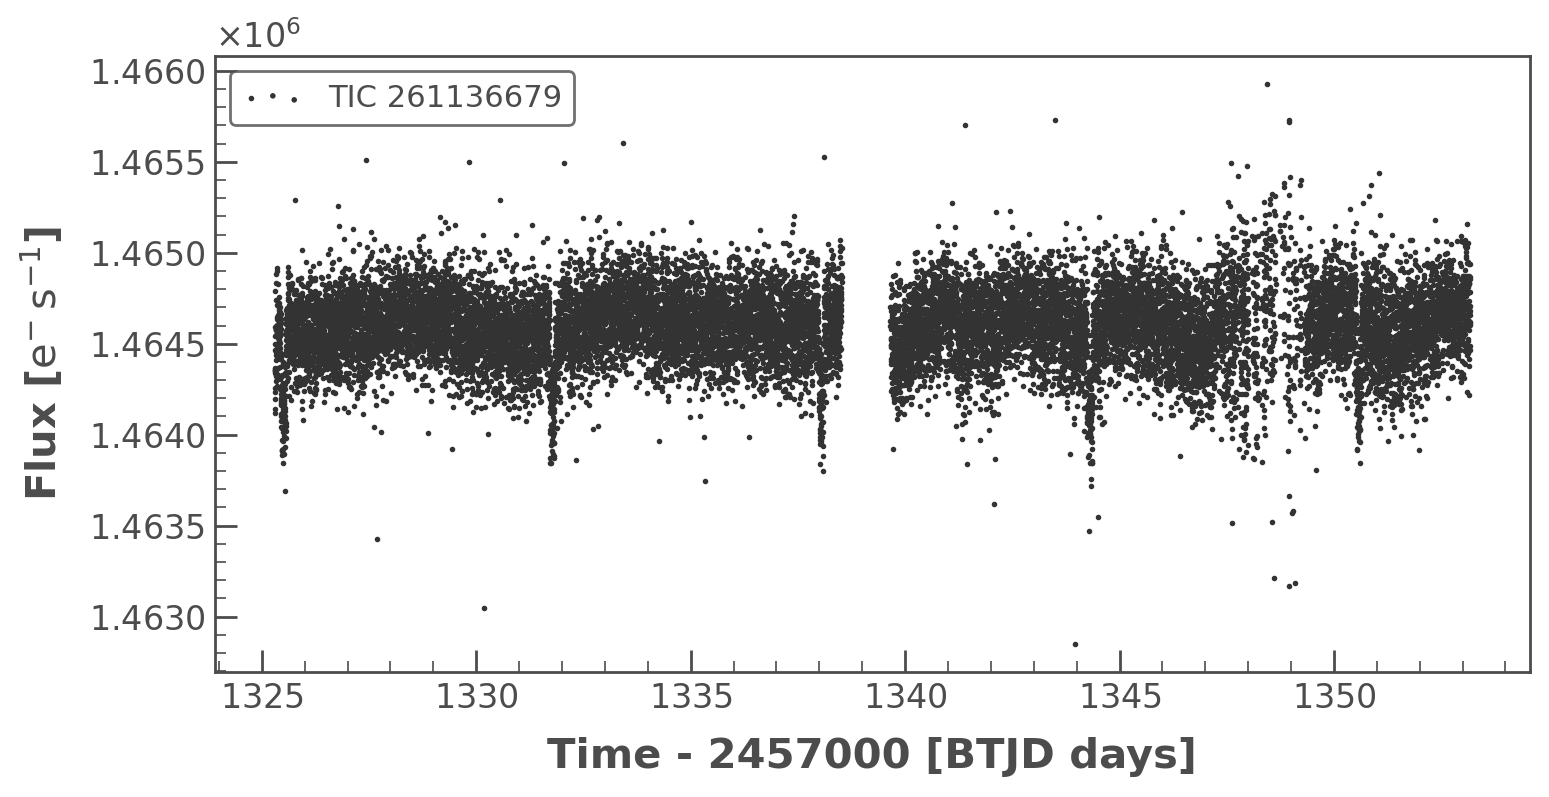

In [5]:
lc.select_flux('pdcsap_flux')
lc.scatter()

Now we have a cleaner light curve, but there are still some long-term trends we might want to remove.

The `flatten` function in lightkurve uses a [Savtizky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) to remove the long-term trends. Here, we have performed the filiter with a window of 501 pixels.

In [6]:
lc_flat = lc.flatten(window_length=501).remove_outliers()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

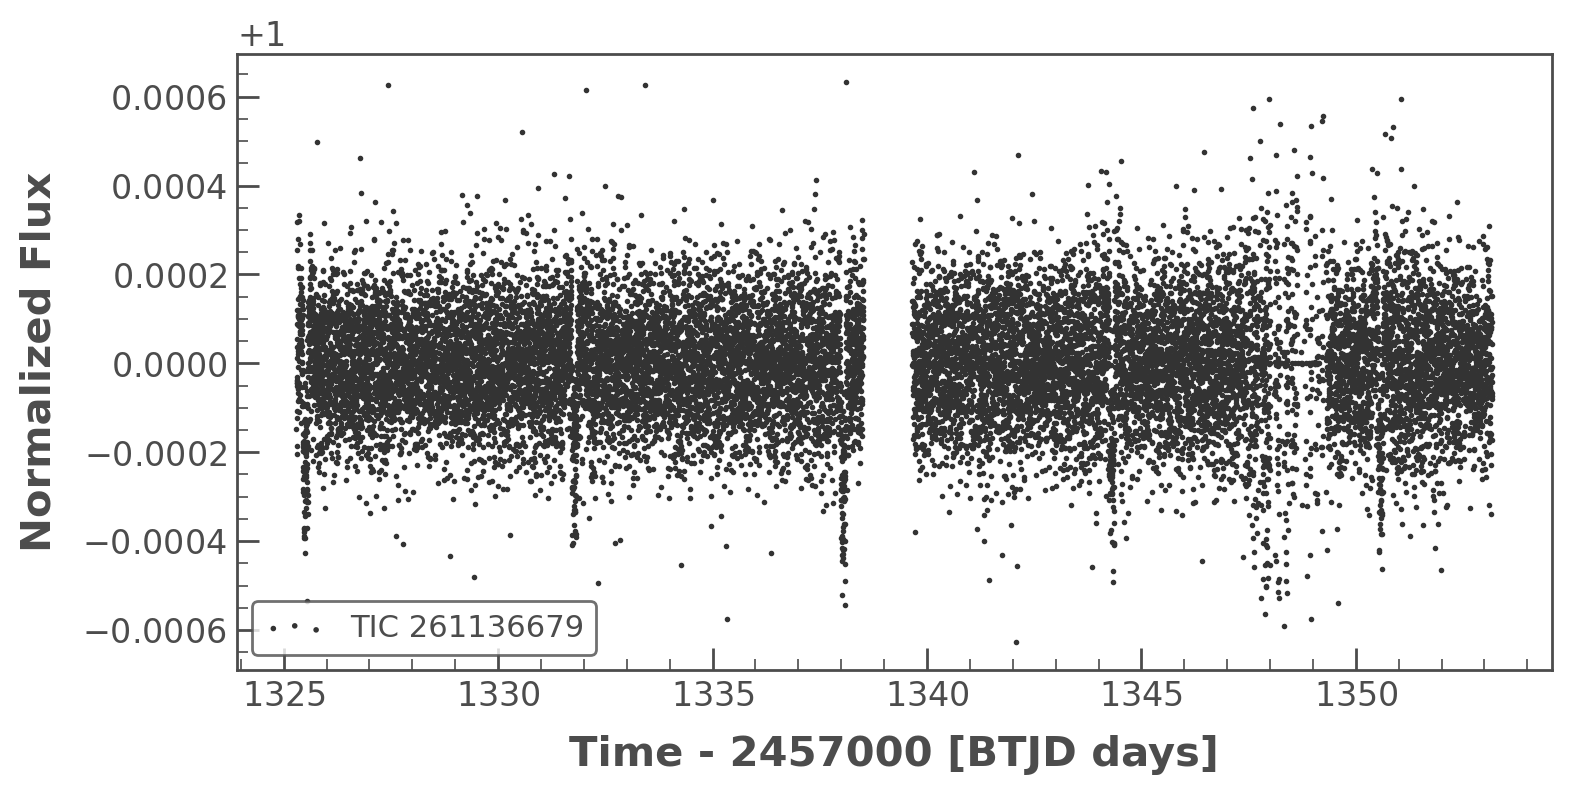

In [7]:
lc_flat.scatter()

That looks better. Now, let's see if we can find the planet transits!

## Search for transits

A common method used to find planetary transits in light curves is the [Box Least Squares algorithm (Kovács, Zucker & Mazeh 2002)](https://arxiv.org/abs/astro-ph/0206099). This searches for a box-like signal in the light curve, and allows us to identify the period of such a signal.

Lightkurve has an in-built function to perform this search. Here, we are using the default parameters, but it's worth digging into the documentation to see all the different parameters that you might change that will help you find planets.

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

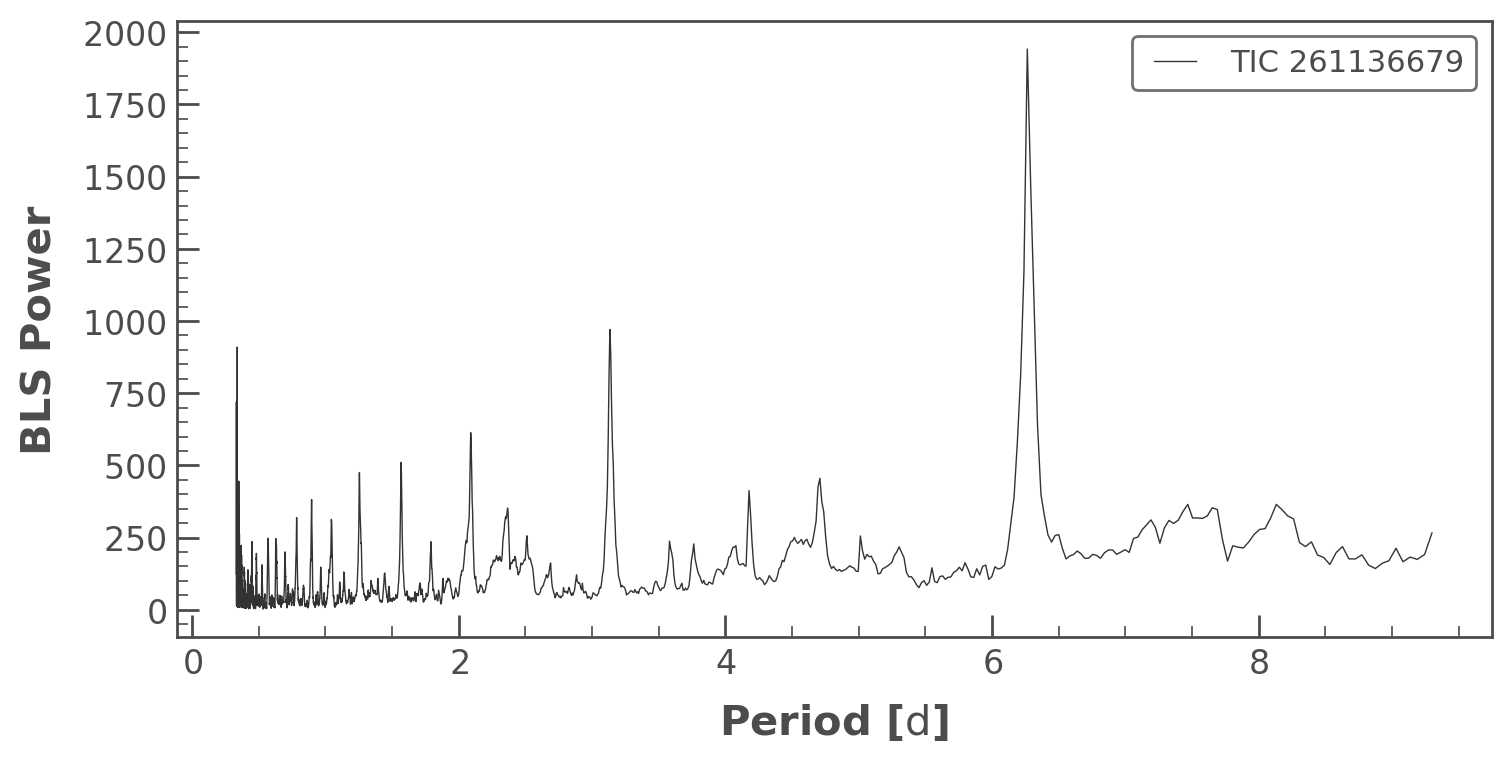

In [8]:
bls = lc.to_periodogram(method='bls')
bls.plot()

This plot, known as a `periodogram`, has peaks where there may be a periodic signal at that frequency. This is similar to a Fourier transform power spectrum.

Here, we clearly see a strong peak at just over two days, hinting that there might be a planet there. Let's find out what that period is.

In [9]:
bls.period_at_max_power

<Quantity 6.26432917 d>

In [10]:
bls.transit_time_at_max_power

<Time object: scale='tdb' format='btjd' value=1325.5119604950603>

Now that we have a period, we can inspect the light curve to see if it's a real signal. We fold the light curve on that period and then plot it. (Folding it means to repeat the time series every $P$ days, where $P$ is the period.)

In [11]:
lc_folded = lc_flat.fold(period=bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power)

In [13]:
lc_binned = lc_folded.bin(time_bin_size=30*u.minute)

(-1.0, 1.0)

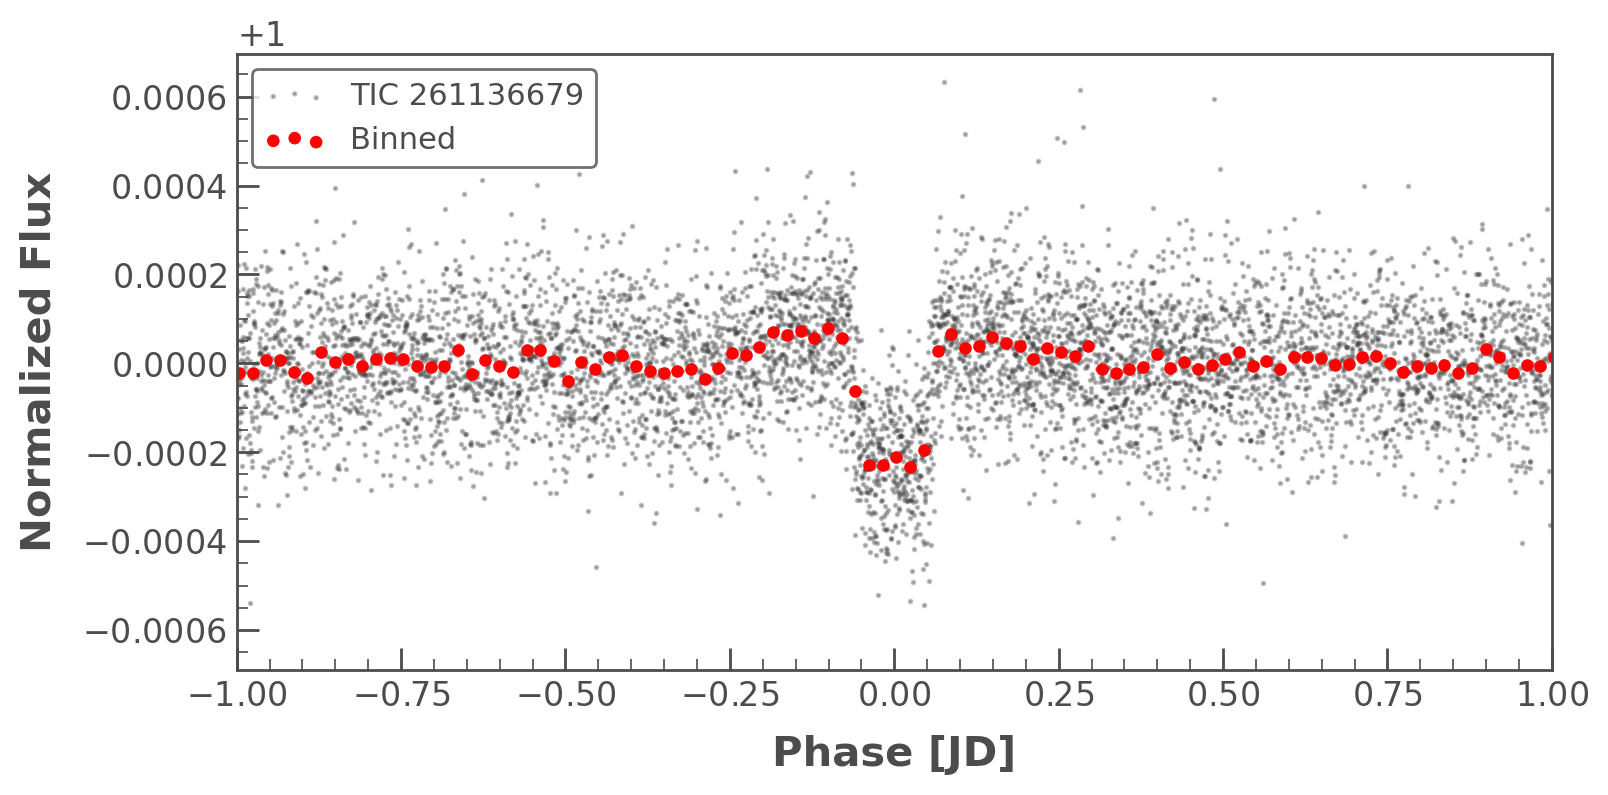

In [14]:
ax = lc_folded.scatter(alpha=0.3)
lc_binned.scatter(ax=ax, s=50, color='red', label='Binned')
ax.set_xlim(-1, 1)

And we clearly see a planet transit! Here, I also binned the data to 30-minute intervals to better see the transit event.

The period and transit time we obtained from the BLS periodogram analysis is similar to what Huang et al. (2018) obtained: 

$P = 6.2679 \pm 0.00046$, $T_c = 1325.50400^{+0.0012}_{-0.00074}$ BTJD

To truly characterize this system, we would need to perform a more detailed fit/analysis of the data, which could be done with a code like [batman](https://github.com/lkreidberg/batman) or [exoplanet](https://github.com/exoplanet-dev/exoplanet).

### Bonus: interactive periodogram

Lightkurve also provides an interactive periodogram that allows you to explore different parameters for the periodogram and select peaks to explore by just clicking on the various plots.

In [ ]:
lc_flat.interact_bls(notebook_url='localhost:8890')

# The TESS Objects of Interest list

If you don't want to search for transit candidates yourself, don't worry! The TESS team has already done that for you. They have published a list of [TESS Objects of Interest](https://exofop.ipac.caltech.edu/tess/view_toi.php) where more than 5,000 vetted transit signals have been logged. Here, you can find additional information about each target, such as the stellar properties and the depth of the transit signal.

You can also download the list and explore it in various ways. Here, we will use pandas, which we saw in a previous week, to do that.

In [15]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [16]:
toi_list = pd.read_csv('https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=pipe',
                       delimiter='|')

In [17]:
toi_list.head()

,TIC ID,TOI,Previous CTOI,Master,SG1A,SG1B,SG2,SG3,SG4,SG5,...,Stellar Radius (R_Sun) err,Stellar Metallicity,Stellar Metallicity err,Stellar Mass (M_Sun),Stellar Mass (M_Sun) err,Sectors,Date TOI Alerted (UTC),Date TOI Updated (UTC),Date Modified,Comments
0,231663901,101.01,NaN,5,5,5,5,5,5,5,...,0.043847,NaN,NaN,1.05,0.129454,"1,27",2018-09-05,2021-10-07,2021-10-29 00:00:00,WASP-46 b
1,149603524,102.01,NaN,5,5,5,5,5,5,5,...,0.050000,0.24,0.05,1.28,0.190812,"1,2,3,4,6,7,8,9,10,11,12,13,27,28,29,30,31,32,...",2019-05-07,2021-08-24,2021-10-29 00:00:00,WASP 62 b
2,336732616,103.01,NaN,5,5,5,5,5,5,5,...,NaN,NaN,NaN,1.27,0.196969,1,2018-09-05,2020-10-27,2021-10-29 00:00:00,HATS-3 b
3,231670397,104.01,NaN,5,5,5,5,5,5,5,...,0.102573,NaN,NaN,1.16,0.166129,"1,27",2018-09-05,2021-12-01,2021-12-07 12:08:34,WASP-73 b
4,144065872,105.01,NaN,5,5,5,5,5,5,5,...,0.059699,NaN,NaN,1.03,0.127209,"1,28",2018-09-05,2021-12-08,2021-12-21 12:05:17,WASP-95; epoch kept from qlp-s28-tois


Here, we plot all the TESS Objects of Interest in period-radius space. We can see that most of the planet candidates are large (Jupiter-sized), because these are the easiest to detect. They also typically have short periods $< 10$ days, since TESS only observes each sector of the sky for 27 days at a time.

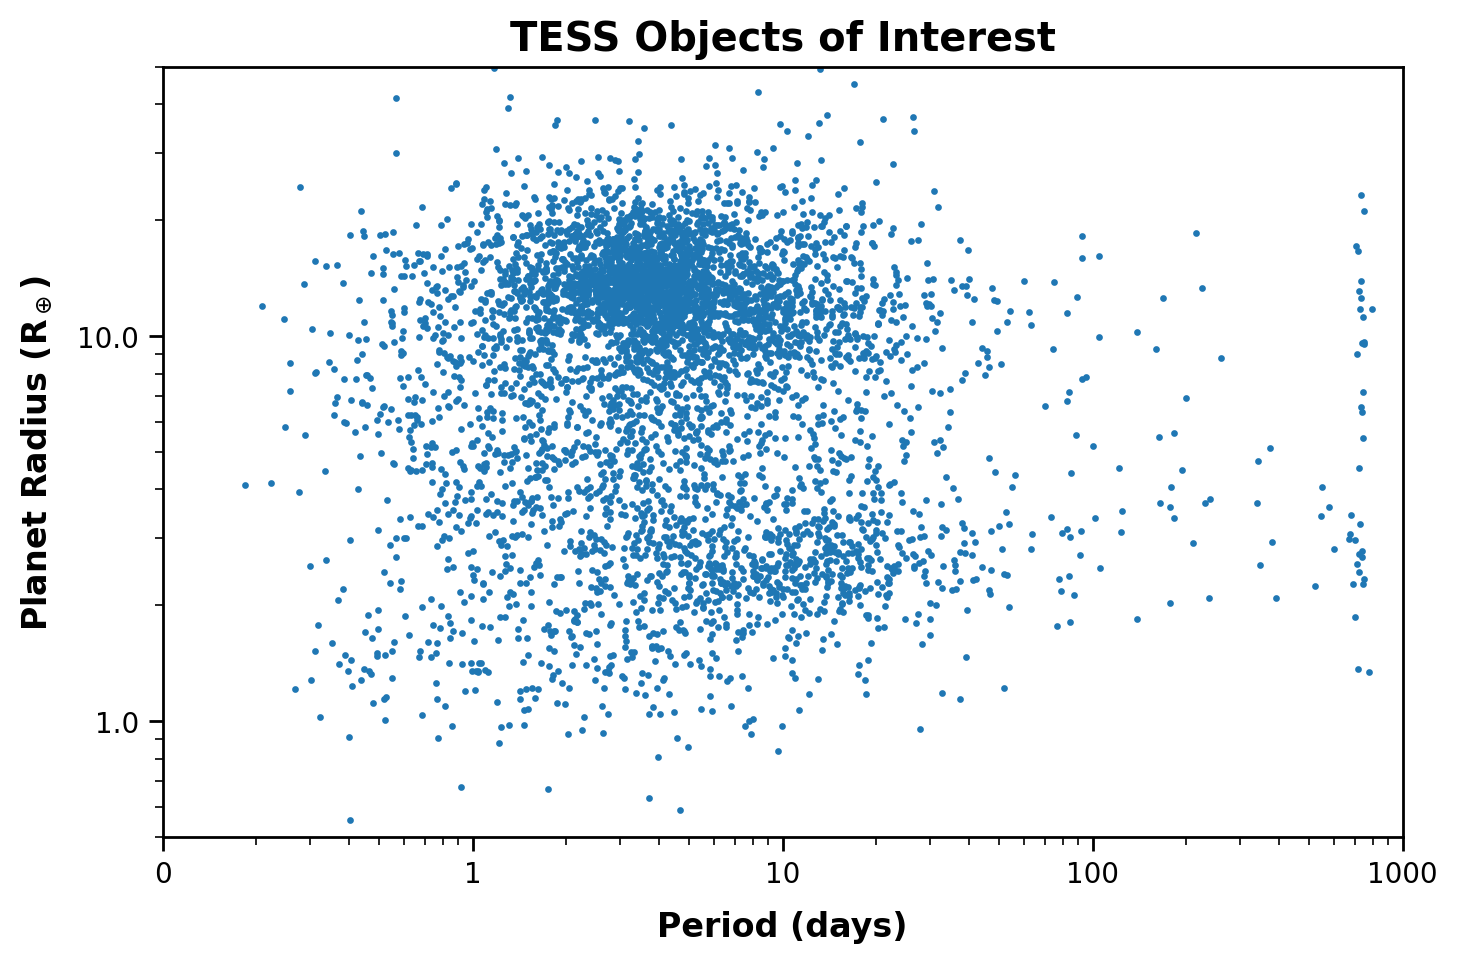

In [18]:
ax = toi_list.plot('Period (days)','Planet Radius (R_Earth)', 
                   kind='scatter', s=2, title='TESS Objects of Interest')
ax.set_xscale('log')
ax.set_xlim(0.1, 1000)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('Planet Radius (R$_\oplus$)')
ax.set_yscale('log')
ax.set_ylim(0.5, 50)
ax.yaxis.set_major_formatter(ScalarFormatter())

# Assignments

## Stitching multiple sectors

Download the data from each sector of TESS observations for Pi Mensae. Detrend them and stitch them together into a single light curve (see [this tutorial](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-combining-multiple-quarters.html) for more information). What is the longest period of planet that you would be able to find in that dataset?

## Searching for a multi-planet system.

Use the TOI list to identify a system with multiple planets (hint: one way to do this is to use the pandas function `duplicated(subset=['TIC ID'])` to identify TIC stars with multiple rows in the TOI list.

Download the data and search it for planets. You will have to do this one planet at a time, and possibly using the `create_transit_mask` function to mask out the transits of each planet you find before searching for the next one. Some additional information can be found at [this page](https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html#5.-Identifying-Additional-Transiting-Planet-Signals-in-the-Same-Light-Curve).

Can you find all the planets at the right period, as identified by the TESS team? You might also find it easier to use the `interact_bls` function to explore the data.